In [1]:
# Check the GPU that we have
!nvidia-smi

Sun Jun 19 15:42:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   78C    P8     9W /  N/A |     10MiB /  5934MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
from matplotlib.ticker import MaxNLocator

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from multiprocessing import cpu_count

### Styling Settings

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10

tqdm.pandas()


In [4]:
# Random Seed Pytorch Lightning
pl.seed_everything(42)

Global seed set to 42


42

## Loading Data

In [5]:
X_train = pd.read_csv("robot_imu_data/X_train.csv")
y_train = pd.read_csv("robot_imu_data/y_train.csv")
print(X_train.shape, y_train.shape)

(487680, 13) (3810, 3)


In [6]:
X_train

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.104880,-0.105970,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.104900,-0.106000,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.104920,-0.105970,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.104950,-0.105970,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.104950,-0.105960,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487675,3809_123,3809,123,0.62871,-0.76878,-0.084391,0.081093,0.003167,0.093760,-0.142740,3.27180,2.0115,-9.0063
487676,3809_124,3809,124,0.62884,-0.76868,-0.084365,0.081099,0.014994,0.032637,-0.132380,4.42750,3.0696,-8.1257
487677,3809_125,3809,125,0.62891,-0.76861,-0.084345,0.081178,-0.031184,-0.003961,-0.138940,2.70480,4.2622,-8.1443
487678,3809_126,3809,126,0.62903,-0.76850,-0.084414,0.081231,-0.069153,0.013229,-0.130210,2.54100,4.7130,-9.4435


In [7]:
y_train

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles
...,...,...,...
3805,3805,55,tiled
3806,3806,67,wood
3807,3807,48,fine_concrete
3808,3808,54,tiled


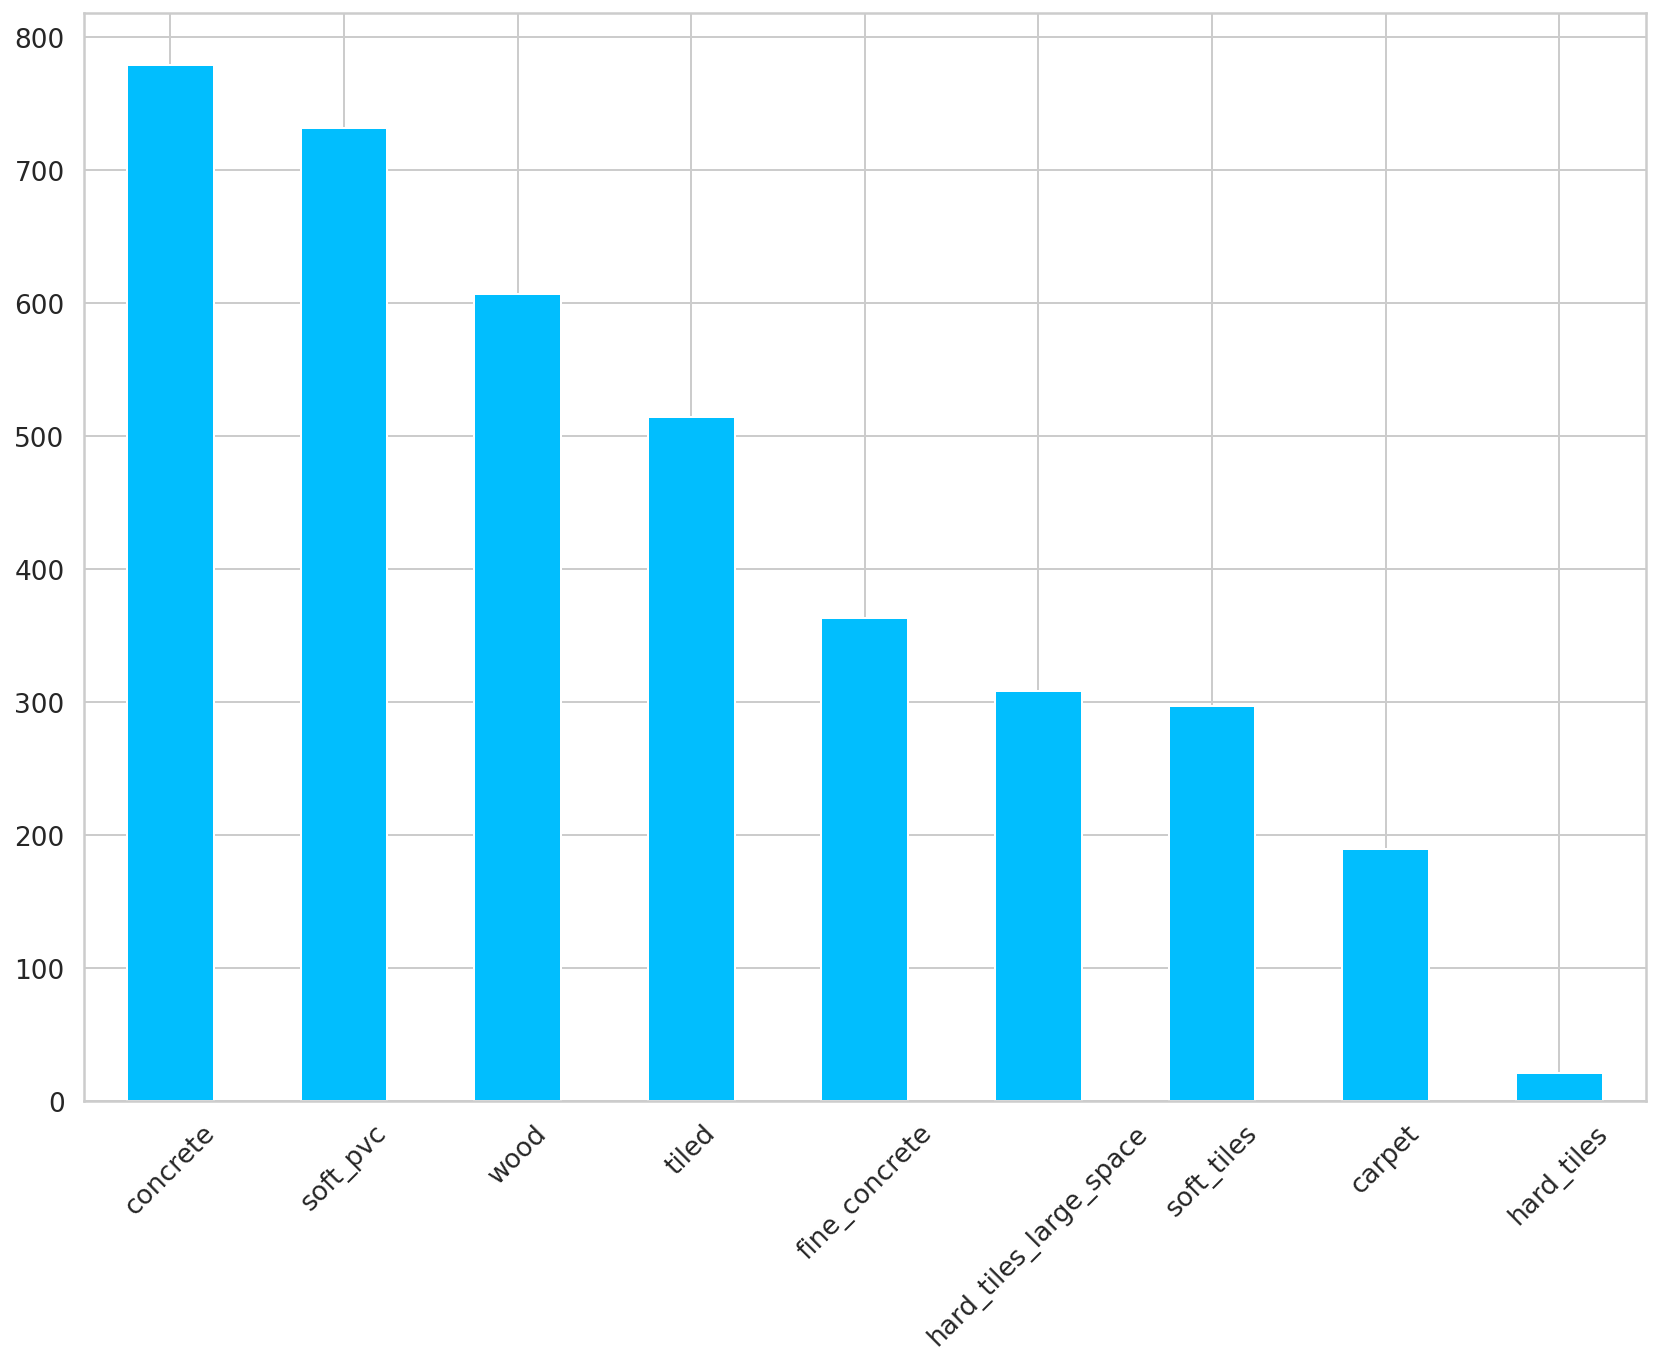

In [8]:
# Checking Data Distribution
y_train.surface.value_counts().plot(kind="bar")
plt.xticks(rotation=45)
plt.show()

# We see that this is not ideal. More data samples of few kind.
# We have unbalaced data
# We might want to use some sort of resampling or balancing the dataset

### Preprocessing the data

In [9]:
# Changing from String Labels to Interger Labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_train.surface)
print(encoded_labels[:10])
print("Label Classes: ", label_encoder.classes_)

[2 1 1 1 6 7 5 1 4 7]
Label Classes:  ['carpet' 'concrete' 'fine_concrete' 'hard_tiles' 'hard_tiles_large_space'
 'soft_pvc' 'soft_tiles' 'tiled' 'wood']


In [10]:
# Adding to y_train df
y_train["label"] = encoded_labels
y_train

,series_id,group_id,surface,label
0,0,13,fine_concrete,2
1,1,31,concrete,1
2,2,20,concrete,1
3,3,31,concrete,1
4,4,22,soft_tiles,6
...,...,...,...,...
3805,3805,55,tiled,7
3806,3806,67,wood,8
3807,3807,48,fine_concrete,2
3808,3808,54,tiled,7


In [11]:
# We only need certain features
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [12]:
FEATURE_COLUMNS = X_train.columns.tolist()[3:]
FEATURE_COLUMNS

['orientation_X',
 'orientation_Y',
 'orientation_Z',
 'orientation_W',
 'angular_velocity_X',
 'angular_velocity_Y',
 'angular_velocity_Z',
 'linear_acceleration_X',
 'linear_acceleration_Y',
 'linear_acceleration_Z']

In [13]:
print(X_train.series_id.value_counts())
# This shows us that each sequence contains 128 datapoints

# confirming this
(X_train.series_id.value_counts() == 128).sum() == len(y_train)


0       128
2544    128
2532    128
2533    128
2534    128
       ... 
1274    128
1275    128
1276    128
1277    128
3809    128
Name: series_id, Length: 3810, dtype: int64


True

### Creating the sequences

I will group by series id

In [14]:
sequences = []
for series_id, group in X_train.groupby("series_id"):
    sequence_features = group[FEATURE_COLUMNS]
    label = y_train[y_train.series_id == series_id].iloc[0].label
    sequences.append((sequence_features, label))

In [15]:
# Each sequence
sequences[0]

(     orientation_X  orientation_Y  orientation_Z  orientation_W  \
 0         -0.75853       -0.63435       -0.10488       -0.10597   
 1         -0.75853       -0.63434       -0.10490       -0.10600   
 2         -0.75853       -0.63435       -0.10492       -0.10597   
 3         -0.75852       -0.63436       -0.10495       -0.10597   
 4         -0.75852       -0.63435       -0.10495       -0.10596   
 ..             ...            ...            ...            ...   
 123       -0.75943       -0.63316       -0.10470       -0.10677   
 124       -0.75945       -0.63313       -0.10473       -0.10683   
 125       -0.75949       -0.63309       -0.10467       -0.10690   
 126       -0.75950       -0.63307       -0.10464       -0.10693   
 127       -0.75953       -0.63306       -0.10461       -0.10684   
 
      angular_velocity_X  angular_velocity_Y  angular_velocity_Z  \
 0              0.107650            0.017561            0.000767   
 1              0.067851            0.029939  

#### Splitting the Sequences into Training and Test Sequences

In [16]:
train_sequences, test_sequences = train_test_split(sequences, test_size=0.2)
print("Number of Training Sequences: ", len(train_sequences))
print("Number of Testing Sequences: ", len(test_sequences))

Number of Training Sequences:  3048
Number of Testing Sequences:  762


### Create PyTorch Dataset

In [17]:
class SurfaceDataset(Dataset):
    def __init__(self, sequences):
        super().__init__()
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]
        return dict(
            sequence = torch.Tensor(sequence.to_numpy()),
            label = torch.tensor(label).long()
        )

In [18]:
class SurfaceDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batch_size):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
    
    def setup(self, stage=None):
        self.train_dataset = SurfaceDataset(self.train_sequences)
        self.test_dataset = SurfaceDataset(self.test_sequences)
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = cpu_count()
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = cpu_count()
        )
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = cpu_count()
        )


### Model Parameters

In [19]:
N_EPOCHS = 250
BATCH_SIZE = 64

data_module = SurfaceDataModule(train_sequences, test_sequences, BATCH_SIZE)

### Model Architecture

In [20]:
class SequenceModel(nn.Module):
  def __init__(self, n_features, n_classes, n_hidden=256, n_layers=3):
    super().__init__()

    self.lstm = nn.LSTM(
        input_size = n_features,
        hidden_size = n_hidden,
        batch_first = True,
        num_layers = n_layers, # Stack LSTMs
        dropout = 0.75  # This model works on a lot of regularisation
    )

    self.classifier = nn.Linear(n_hidden, n_classes)

  def forward(self, x):
    self.lstm.flatten_parameters()  # For distrubuted training

    _, (hidden, _) = self.lstm(x)
    # We want the output from the last layer to go into the final
    # regressor linear layer
    out = hidden[-1] 

    return self.classifier(out)

In [27]:
class SurfacePredictor(pl.LightningModule):
    def __init__(self, n_features: int, n_classes: int):
        super().__init__()
        self.model = SequenceModel(n_features, n_classes)
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    
    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self.forward(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = accuracy(predictions, labels)

        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.log("train_accuracy", step_accuracy, prog_bar=True, logger=True)
        
        return {"loss": loss, "accuracy": step_accuracy}
    
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self.forward(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = accuracy(predictions, labels)

        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_accuracy", step_accuracy, prog_bar=True, logger=True)
        
        return {"loss": loss, "accuracy": step_accuracy}
    
    def configure_optimizers(self):
        return optim.Adam(self.model.parameters(), lr=0.0001)

In [28]:
# Model
model = SurfacePredictor(
    n_features=len(FEATURE_COLUMNS),
    n_classes=len(label_encoder.classes_)
)

In [29]:
# Starting tensorboard
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 10417), started 0:12:03 ago. (Use '!kill 10417' to kill it.)

### Training the Model

In [30]:
# Callbacks

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k = 1,
    verbose = True,
    monitor = "val_loss",
    mode = "min"
)

logger = TensorBoardLogger("lightning_logs", name = "surface_predictor")

early_stopping_callback = EarlyStopping(monitor = "val_loss", patience = 2)

In [33]:
# Trainer
trainer = pl.Trainer(
    logger = logger,
    checkpoint_callback = checkpoint_callback,
    #callbacks = [early_stopping_callback],
    max_epochs = N_EPOCHS,
    gpus = 1,
    progress_bar_refresh_rate = 30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [34]:
trainer.fit(model, data_module)

/home/khalid/venvs/torchy/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory lightning_logs/surface_predictor/version_2/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SequenceModel    | 1.3 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.318     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [36]:
#trainer.test()

## Preditions

In [40]:
checkpoint_path = "/home/khalid/Desktop/pytorch_learn/Part 15 - Multivariate_Time_ Series_Classification_PyTorch_Lightning/lightning_logs/surface_predictor/version_2/checkpoints/epoch=249-step=12000.ckpt"

trained_model = SurfacePredictor.load_from_checkpoint(
    checkpoint_path,
    n_features = len(FEATURE_COLUMNS),
    n_classes = len(label_encoder.classes_)
)
trained_model.freeze()

In [52]:
test_dataset = SurfaceDataset(test_sequences)

predictions = []
labels = []

for item in tqdm(test_dataset):
    sequence = item["sequence"]
    label = item["label"]

    _, output = trained_model(sequence.unsqueeze(dim=1))
    #print(output.shape)
    prediction = torch.argmax(output, dim=1)
    #print(torch.mode(prediction, 0)[0].item())
    #break
    predictions.append(torch.mode(prediction, 0)[0].item())
    labels.append(label.item())

  0%|          | 0/762 [00:00<?, ?it/s]

In [55]:
print(
    classification_report(
        labels, predictions, target_names=label_encoder.classes_
    )
)

                        precision    recall  f1-score   support

                carpet       0.00      0.00      0.00        47
              concrete       0.00      0.00      0.00       172
         fine_concrete       0.09      0.57      0.16        65
            hard_tiles       0.00      0.00      0.00         5
hard_tiles_large_space       0.00      0.00      0.00        63
              soft_pvc       0.00      0.00      0.00       141
            soft_tiles       0.00      0.00      0.00        63
                 tiled       0.15      0.61      0.24        89
                  wood       0.00      0.00      0.00       117

              accuracy                           0.12       762
             macro avg       0.03      0.13      0.04       762
          weighted avg       0.03      0.12      0.04       762



/home/khalid/venvs/torchy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/khalid/venvs/torchy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/khalid/venvs/torchy/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Confusion Matrix

In [60]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    # hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklables(), rotation=0, ha="right")
    # hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklables(), rotation=30, ha="right")
    plt.ylabel("Surface Ground Truth")
    plt.xlabel("Predicted Surface")
    plt.legend()


In [61]:
cm = confusion_matrix(labels, predictions)
df_cm = pd.DataFrame(
    cm, 
    index = label_encoder.classes_,
    columns = label_encoder.classes_
)
df_cm

,carpet,concrete,fine_concrete,hard_tiles,hard_tiles_large_space,soft_pvc,soft_tiles,tiled,wood
carpet,0,0,14,0,0,0,0,33,0
concrete,0,0,64,0,0,0,0,108,0
fine_concrete,0,0,37,0,0,0,0,28,0
hard_tiles,0,0,2,0,0,0,0,3,0
hard_tiles_large_space,0,0,26,0,0,0,0,37,0
soft_pvc,0,0,113,0,0,0,0,28,0
soft_tiles,0,0,42,0,0,0,0,21,0
tiled,0,0,35,0,0,0,0,54,0
wood,0,0,73,0,0,0,0,44,0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


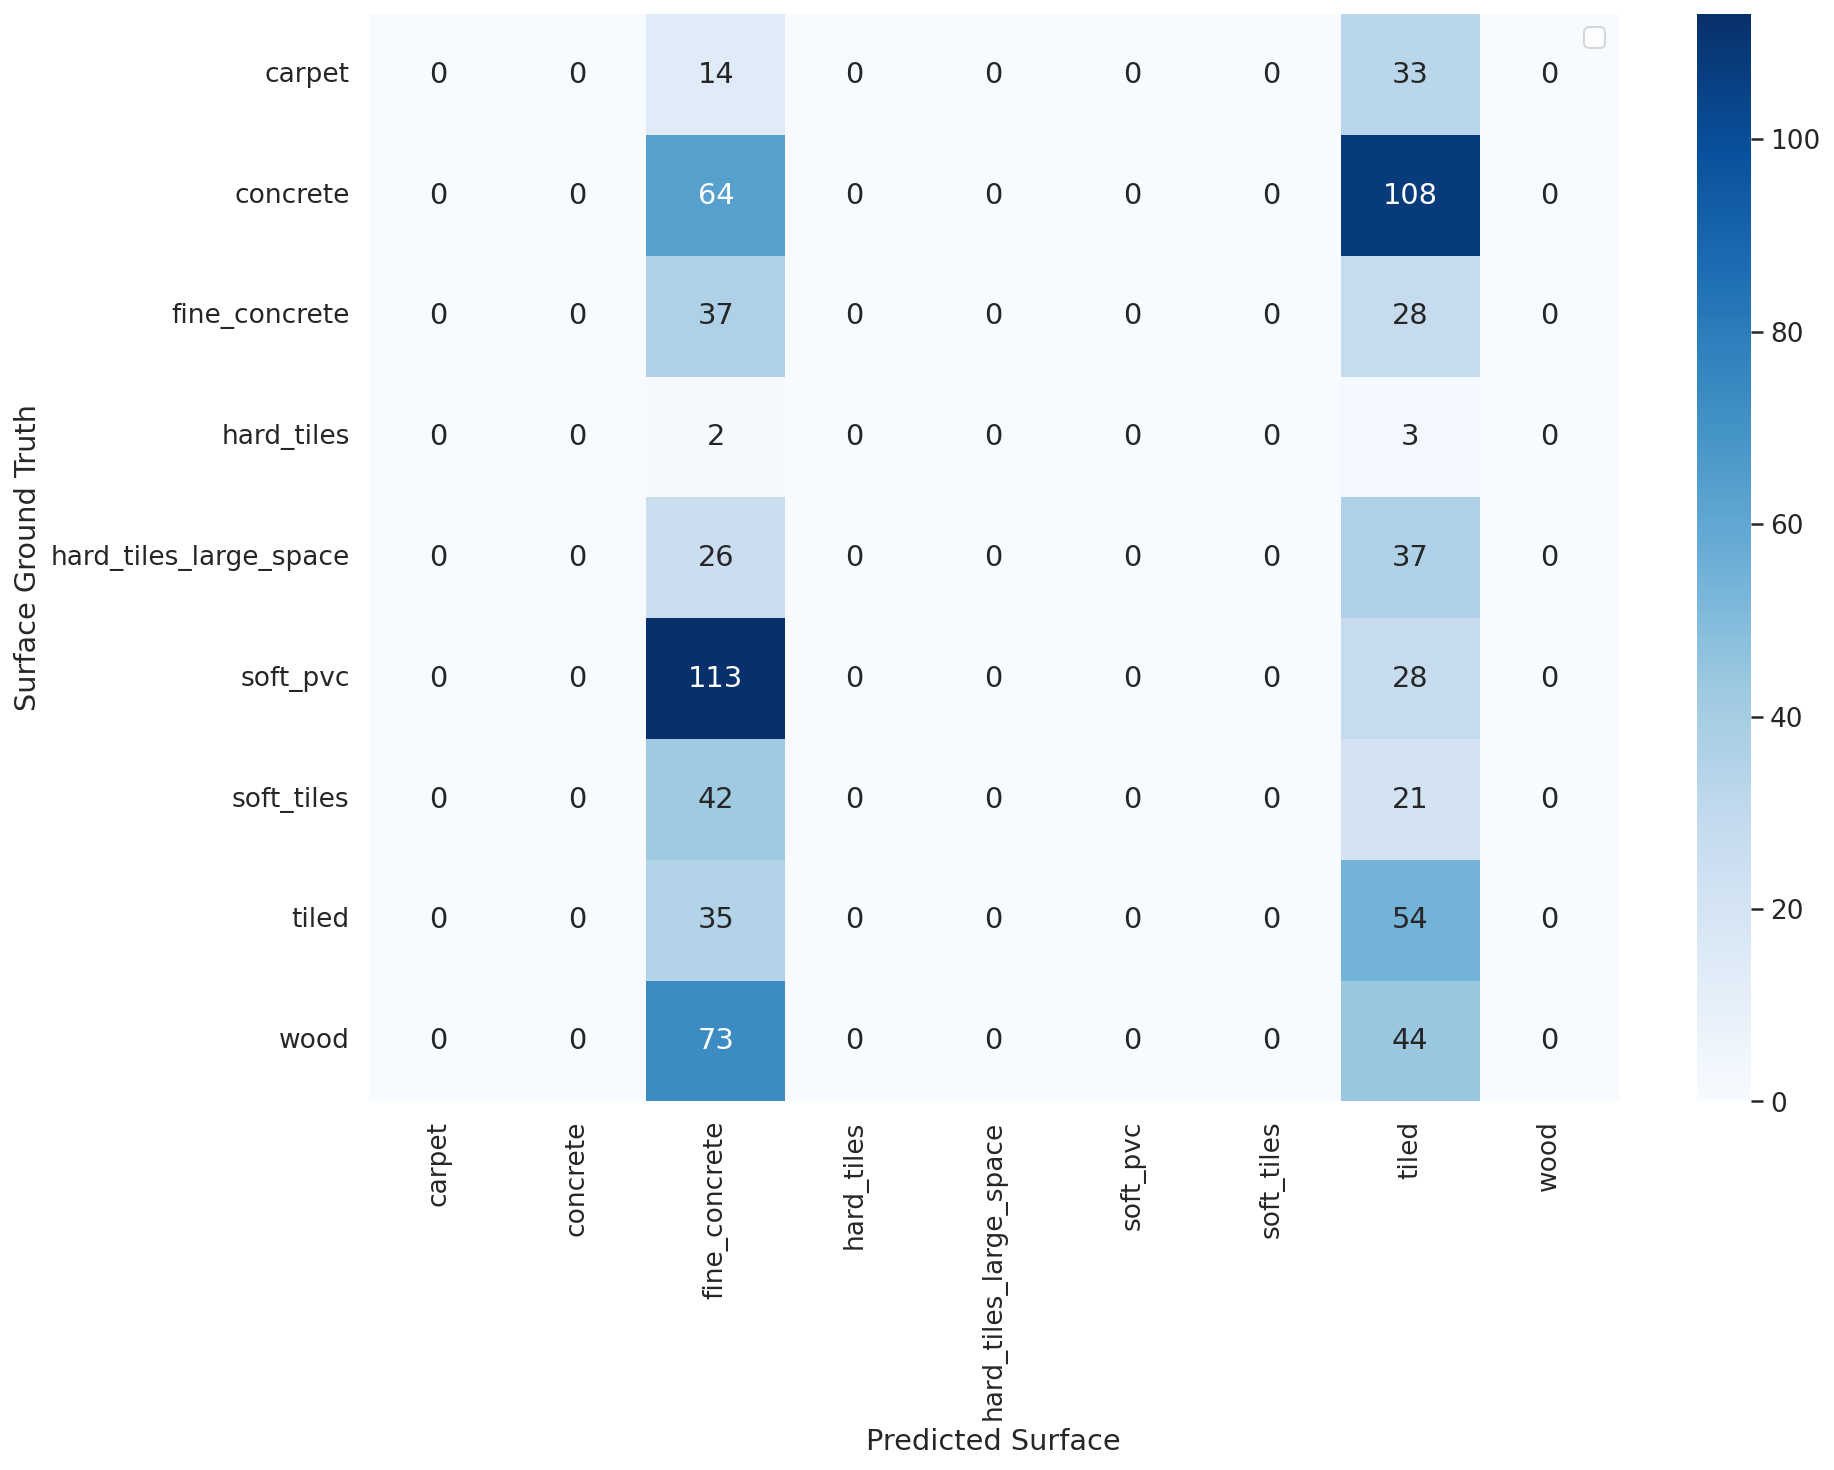

In [62]:
show_confusion_matrix(df_cm)